# Assignment 2

Visit the "Publications" section of the [Hugo Steinhaus Center website](http://prac.im.pwr.wroc.pl/~hugo/HSC/hsc.html). Scrape the data on research papers from that site and generate a cooperation network of authors in the following way:

1. Members of HSC are the nodes.
2. The size of a node is proportional to the number of papers co-authored by the node.
3. A link between two nodes means a paper written together by the corresponding members.
4. A weight of the link indicates the total number of common papers.

Visualize the network (with names and link weights). Detect the connected components.

## Obtaining the data

The first thing to do is to request the resource from the webpage. For this we will use the `requests` library.

In [1]:
import requests

And define the [URL](https://en.wikipedia.org/wiki/URL) which we will be requesting.

In [2]:
URL = r"http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html"

We will be using the `GET` method so we call an appropriate function.

In [3]:
try:
    response = requests.get(URL, timeout=5)
    response.raise_for_status()  # Raise appropriate error in case the request is unsuccessful
except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except Exception as err:
    print(f"Other error occurred: {err}")

We can also check the status code of the response

In [4]:
response.status_code

200

To avoid unnecessary ecoding problems let's check the encoding and change it to UTF-8 if it's not already

In [5]:
response.encoding 

'ISO-8859-1'

In [6]:
response.encoding = 'utf-8'

## Parsing HTML

To parse the HTML text into document tree we will use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library.

In [7]:
import bs4
from bs4 import BeautifulSoup

In [8]:
html = BeautifulSoup(response.content)

If we look at the site we will see that data which is interesting to us can be found in the "Reasearch Papers" section. There, for each year separately, exists a list with authors and the paper title. What's even better is that staff members names are written in bold font.

In [9]:
research_papers = html.find(attrs={'name': '#Research papers'})

Going two levels up in the hierarchy we will get to the `<h2>` tag which will be sibling to the lists containing the articles.

In [10]:
h2 = research_papers.parent.parent

**Remark:** We have to be careful to stop at the next `<h2>` tag. Otherwise we will include the "Research reports" in our data and we are not interested in that.

We will represent the scrapped data in a dictionary where each year corresponds to list of articles. Each article will itself be a dictionary with three keys:
1. `authors` - authors of the paper.
2. `local_authors` - authors of the paper which are HSC staff.
3. `title` - title of the paper.

We will use two additional libraries 
1. `collections` for more readable code using `collections.defaultdict`.
2. `regex` for deciding which piece of text corresponds to what category.

In [11]:
import collections
import regex

We also define a `content_type` function, which will use regexes to categorize each term to one of four categories: *name*, *year*, *title* or *other*.

In [12]:
def content_type(string: str) -> str:
    """bla bla bla"""
#     string = string.strip()
    if regex.match(r'^(\pL[.][ ]?)+\pL[a-z]+', string):
        return 'name'
    elif regex.match(r'^[\d]{4}$', string):
        return 'year'
    elif regex.match(r'^".+"$', string):
        return 'title'
    else:
        return 'other'

Exemplary usage is ilustrated below:

In [13]:
content_type('A. B. Aak')

'name'

In [14]:
content_type('1234')

'year'

In [15]:
content_type('"aloha"')

'title'

In [16]:
content_type('Alice has a cat.')

'other'

If we look at the data we will notice that sometimes the names are written using Polish alphabet and sometimes they are not. To match according names we will add a single function which will project Polish characters into according English ones.

In [17]:
def remove_polish_characters(string):
    POLISH_LETTERS_PROJECTION = {
        'ą': 'a',
        'ć': 'c',
        'ę': 'e',
        'ł': 'l',
        'ń': 'n',
        'ó': 'o',
        'ś': 's',
        'ź': 'z',
        'ż': 'z'
    }
    new_string = string
    for letter, replacement in POLISH_LETTERS_PROJECTION.items():
        new_string = str.replace(new_string, letter, replacement)
    return new_string

Example usage:

In [18]:
remove_polish_characters('A niechaj narodowie wżdy postronni znają, iż Polacy nie gęsi, iż swój język mają.')

'A niechaj narodowie wzdy postronni znaja, iz Polacy nie gesi, iz swoj jezyk maja.'

We also define `process_list` function which, given a `<ol>` tag processes each item within and returns list of articles.

In [19]:
def process_list(ol):  # ol - ordered list (HTML tag)
    list_data = []
    for li in ol.find_all('li'):
        article_data = collections.defaultdict(list)
        for font in li.find_all('font'): 
            content = font.string
            if content:  # Not empty
                type_ = content_type(content)
                processed_content = content.strip()
            if type_ == 'name':
                processed_content = str.replace(processed_content, ' ', '')  # Remove spaces from names
                processed_content = remove_polish_characters(processed_content)
                article_data['authors'].append(processed_content)
                if content.parent.name == 'b':
                    article_data['local_authors'].append(processed_content)
            elif type_ == 'title':
                article_data['title'] = processed_content
        list_data.append(article_data)
    return list_data

Finally we can process all the data:

In [20]:
data = collections.defaultdict(list)
for sibling in h2.next_siblings:
    if isinstance(sibling, bs4.Tag): # Process only valid tags
        if sibling.name == 'h2':
            break  # Break at "Research reports"
            
        try:
            year = sibling['name']  # Update year of publication
        except KeyError:
            pass
        
        if sibling.name == 'ol':
            data[year].extend(process_list(sibling))

And we can display it

In [21]:
data

defaultdict(list,
            {'2020': [defaultdict(list,
                          {'authors': ['J.Gruszka', 'J.Szwabinski'],
                           'local_authors': ['J.Gruszka', 'J.Szwabinski'],
                           'title': '"Best Portfolio Management Strategies For Synthetic and Real Assets"'}),
              defaultdict(list,
                          {'authors': ['A.Grzesiek', 'A.Wylomanska'],
                           'local_authors': ['A.Grzesiek', 'A.Wylomanska'],
                           'title': '"Subordinated Processes with Infinite Variance"'}),
              defaultdict(list,
                          {'authors': ['A.Michalak',
                            'J.Wodecki',
                            'A.Wylomanska',
                            'R.Zimroz'],
                           'local_authors': ['A.Wylomanska'],
                           'title': '"Influence of Signal to Noise Ratio on the Effectiveness of Cointegration Analysis for Vibration Signal"'}),
  

## Transforming the data

With the data prepared we can start transforming the data to a form which will be most suitable for network visualizations.

In [22]:
authors = []

In [23]:
for year, articles in data.items():
    for article in articles:
        if article['local_authors']:  # Consider only non-empty lists
            authors.append(article['local_authors'])

In [24]:
authors[:10]

[['J.Gruszka', 'J.Szwabinski'],
 ['A.Grzesiek', 'A.Wylomanska'],
 ['A.Wylomanska'],
 ['P.Kruczek', 'A.Wylomanska'],
 ['A.Wylomanska'],
 ['Z.Palmowski'],
 ['M.Balcerek', 'H.Loch-Olszewska', 'A.Weron', 'K.Burnecki'],
 ['Z.Palmowski'],
 ['Z.Palmowski'],
 ['K.Burnecki', 'Z.Palmowski']]

### Counting how many articles each person wrote/co-authored

To unpack a list of list we will use a classic, but rather unreadable list comprehension (*even python has its cons*).

In [25]:
names = [item for list_ in authors for item in list_]

We now can easily (using `collections.Counter`) count how many articles each person wrote/co-authored

In [26]:
author_counts = collections.Counter(names)
author_counts

Counter({'J.Gruszka': 1,
         'J.Szwabinski': 7,
         'A.Grzesiek': 6,
         'A.Wylomanska': 118,
         'P.Kruczek': 9,
         'Z.Palmowski': 27,
         'M.Balcerek': 4,
         'H.Loch-Olszewska': 4,
         'A.Weron': 90,
         'K.Burnecki': 73,
         'G.Sikora': 26,
         'M.Teuerle': 19,
         'A.Wilkowska': 1,
         'A.Kumar': 1,
         'P.Kowalek': 1,
         'R.Poloczanski': 5,
         'M.Magdziarz': 67,
         'A.Michalak': 1,
         'Ł.Bielak': 1,
         'J.Janczura': 24,
         'J.Ślezak': 8,
         'G.Żak': 9,
         'D.Kucharczyk': 2,
         'A.Fulinski': 1,
         'J.Gajda': 21,
         'J.Sokolowski': 1,
         'A.Stanislavsky': 2,
         'J.Goncerzewicz': 1,
         'H.Loch': 1,
         'J.Obuchowski': 18,
         'G.Zak': 1,
         'W.Okrasinski': 9,
         'M.Muszkieta': 4,
         'R.Weron': 84,
         'S.Orzel': 6,
         'W.Mydlarczyk': 1,
         'A.Jurlewicz': 36,
         'J.Iwanik': 2,
    

To see who is on the podium we can simply sort the dictionary's items and get the first three values:

In [27]:
sorted(author_counts.items(), key=lambda x: x[1], reverse=True)[:3]

[('A.Wylomanska', 118), ('A.Weron', 90), ('R.Weron', 84)]

### Edges with weigths

To generate the graph it will be easiest to have a dictionary of edges with corresponding number of common articles (to adjust the sizes).

As each edge should connect only two persons we will split longer lists into all possible combinations of length two using `itertools.combinations` function.

In [28]:
import itertools

In [29]:
edges = collections.defaultdict(int)
for author_list in authors:
    if len(author_list) > 1:  # Consider only connected edges
        for permutation in itertools.combinations(author_list, 2):
            edges[permutation] += 1

In [30]:
edges

defaultdict(int,
            {('J.Gruszka', 'J.Szwabinski'): 1,
             ('A.Grzesiek', 'A.Wylomanska'): 6,
             ('P.Kruczek', 'A.Wylomanska'): 8,
             ('M.Balcerek', 'H.Loch-Olszewska'): 1,
             ('M.Balcerek', 'A.Weron'): 1,
             ('M.Balcerek', 'K.Burnecki'): 2,
             ('H.Loch-Olszewska', 'A.Weron'): 2,
             ('H.Loch-Olszewska', 'K.Burnecki'): 1,
             ('A.Weron', 'K.Burnecki'): 7,
             ('K.Burnecki', 'Z.Palmowski'): 1,
             ('K.Burnecki', 'G.Sikora'): 8,
             ('K.Burnecki', 'A.Weron'): 24,
             ('G.Sikora', 'A.Weron'): 6,
             ('K.Burnecki', 'M.Teuerle'): 2,
             ('K.Burnecki', 'A.Wilkowska'): 1,
             ('M.Teuerle', 'A.Wilkowska'): 1,
             ('A.Wylomanska', 'A.Kumar'): 1,
             ('A.Grzesiek', 'M.Teuerle'): 1,
             ('M.Teuerle', 'A.Wylomanska'): 7,
             ('P.Kowalek', 'H.Loch-Olszewska'): 1,
             ('P.Kowalek', 'J.Szwabinski'): 1,
       

## Generating the graph

With all the data prepared we can easily generate the graph:

In [31]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [32]:
matplotlib.rcParams['figure.figsize']= [12, 12]

In [33]:
graph = nx.Graph()

In [34]:
for node, count in author_counts.items():
    graph.add_node(node, weigth=count)

In [35]:
for edge, count in edges.items():
    graph.add_edge(*edge, weigth=count)

In [36]:
# graph.edges(data=True)

In [37]:
# graph.nodes(data=True)

C:\Users\kboch\Miniconda3\envs\networks\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


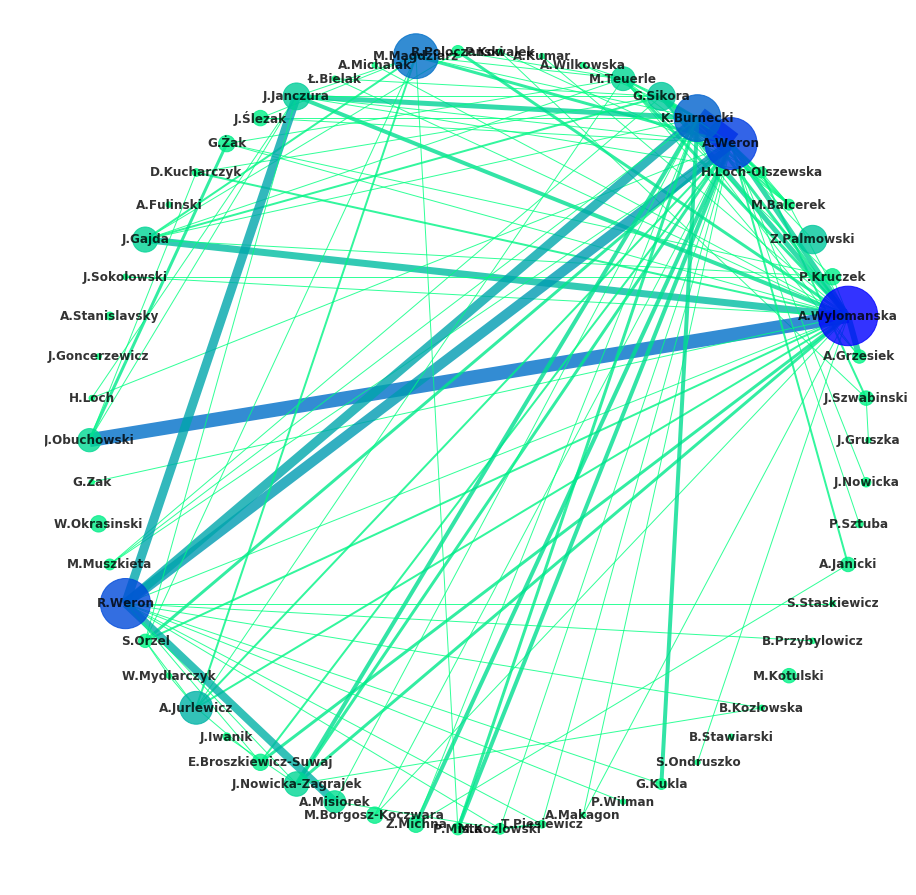

In [38]:
nx.draw_circular(graph, 
                 with_labels=True, 
                 node_size=[node['weigth'] * 30 for _, node in graph.nodes(data=True)], 
                 node_color=[node['weigth'] * 30 for _, node in graph.nodes(data=True)],
                 width=[edge['weigth'] for *_, edge in graph.edges(data=True)],
                 edge_color=[edge['weigth'] for *_, edge in graph.edges(data=True)],
                 cmap='winter_r',
                 edge_cmap=plt.get_cmap('winter_r'),
                 font_weight='bold',
                 alpha=0.8)

As we have seen previously the most prominent authors are: prof. A. Wylomanska, prof. R. Weron, prof. A. Weron and prof. K. Burnecki. The biggest number of coauthored papers is beetween prof. J. Obuchowski and prof. A. Wylomanska.